In [17]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
import pandas as pd
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.metrics import AUC
from keras.metrics import Recall
from keras.metrics import Precision
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import os

In [26]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive_ = GoogleDrive(gauth)

In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
id_train_features = '1LnKdehYxXYXIUhxO1NFeu5GebmKpbYjY'
id_test_features = '1CIuprbEUeJDEdg0WO5Sq2-xV8OBElXLX'
id_train_labels = '1dzgH430IP8VV4Jw6InbfTiMEFUxZk1pO'
id_test_labels = '10dwdJ5EI_w-HfeM3F8CyctlqAnuW3RY9'

In [27]:
downloaded = drive_.CreateFile({'id':id_train_features})   # replace the id with id of file you want to access
downloaded.GetContentFile('train_features.csv')  
# Dataset is now stored in a Pandas Dataframe
train_X = pd.read_csv('train_features.csv',header=None)
train_X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,0.087,0.106,0.059,0.170,0.084,0.090,0.052,0.153,0.159,0.049,0.086,0.055,0.080,0.052,0.098,0.038,0.059,0.177,0.047,0.046,0.205,0.090,0.127,0.181,0.171,0.106,0.193,0.059,0.082,0.205,0.079,0.066,0.101,0.061,0.126,0.165,0.075,0.165,0.199,0.056,0.072
1,0.106,0.059,0.170,0.084,0.090,0.052,0.153,0.159,0.049,0.086,0.055,0.080,0.052,0.098,0.038,0.059,0.177,0.047,0.046,0.205,0.090,0.127,0.181,0.171,0.106,0.193,0.059,0.082,0.205,0.079,0.066,0.101,0.061,0.126,0.165,0.075,0.165,0.199,0.056,0.072,0.228
2,0.059,0.170,0.084,0.090,0.052,0.153,0.159,0.049,0.086,0.055,0.080,0.052,0.098,0.038,0.059,0.177,0.047,0.046,0.205,0.090,0.127,0.181,0.171,0.106,0.193,0.059,0.082,0.205,0.079,0.066,0.101,0.061,0.126,0.165,0.075,0.165,0.199,0.056,0.072,0.228,0.123
3,0.170,0.084,0.090,0.052,0.153,0.159,0.049,0.086,0.055,0.080,0.052,0.098,0.038,0.059,0.177,0.047,0.046,0.205,0.090,0.127,0.181,0.171,0.106,0.193,0.059,0.082,0.205,0.079,0.066,0.101,0.061,0.126,0.165,0.075,0.165,0.199,0.056,0.072,0.228,0.123,0.019
4,0.084,0.090,0.052,0.153,0.159,0.049,0.086,0.055,0.080,0.052,0.098,0.038,0.059,0.177,0.047,0.046,0.205,0.090,0.127,0.181,0.171,0.106,0.193,0.059,0.082,0.205,0.079,0.066,0.101,0.061,0.126,0.165,0.075,0.165,0.199,0.056,0.072,0.228,0.123,0.019,0.123


In [28]:
downloaded = drive_.CreateFile({'id':id_test_features})   # replace the id with id of file you want to access
downloaded.GetContentFile('test_features.csv')  
# Dataset is now stored in a Pandas Dataframe
test_X = pd.read_csv('test_features.csv',header=None)
test_X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.090,0.077,0.077,0.073,0.067,0.054,0.092,0.085,0.083,0.182,0.098,0.229,0.096,0.113,0.148,0.050,0.045,0.069,0.133,0.131,0.154
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.090,0.077,0.077,0.073,0.067,0.054,0.092,0.085,0.083,0.182,0.098,0.229,0.096,0.113,0.148,0.050,0.045,0.069,0.133,0.131,0.154,0.182
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.090,0.077,0.077,0.073,0.067,0.054,0.092,0.085,0.083,0.182,0.098,0.229,0.096,0.113,0.148,0.050,0.045,0.069,0.133,0.131,0.154,0.182,0.096
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.090,0.077,0.077,0.073,0.067,0.054,0.092,0.085,0.083,0.182,0.098,0.229,0.096,0.113,0.148,0.050,0.045,0.069,0.133,0.131,0.154,0.182,0.096,0.236
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09,0.077,0.077,0.073,0.067,0.054,0.092,0.085,0.083,0.182,0.098,0.229,0.096,0.113,0.148,0.050,0.045,0.069,0.133,0.131,0.154,0.182,0.096,0.236,0.082


In [29]:
downloaded = drive_.CreateFile({'id':id_train_labels})   # replace the id with id of file you want to access
downloaded.GetContentFile('train_labels.csv')  
# Dataset is now stored in a Pandas Dataframe
train_Y = pd.read_csv('train_labels.csv',header=None)
train_Y.head()

,0
0,1
1,1
2,1
3,1
4,1


In [30]:
downloaded = drive_.CreateFile({'id':id_test_labels})   # replace the id with id of file you want to access
downloaded.GetContentFile('test_labels.csv')  
# Dataset is now stored in a Pandas Dataframe
test_Y = pd.read_csv('test_labels.csv',header=None)
test_Y.head()

,0,1,2,3,4,5
0,c,l,a,s,s,2
1,c,l,a,s,s,2
2,c,l,a,s,s,2
3,c,l,a,s,s,2
4,c,l,a,s,s,2


In [31]:
test_Y = test_Y[5]

In [32]:
train_y = np.array(train_Y)
test_y = np.array(test_Y)
train_x = list()
train_x.append(train_X)
train_x = np.dstack(train_x)
test_x = list()
test_x.append(test_X)
test_x = np.dstack(test_x)
print('Shape of the train features tensor',train_x.shape)
print('Shape of the train labels tensor',train_y.shape)
print('Shape of the test features tensor',test_x.shape)
print('Shape of the test labels tensor',test_y.shape)

Shape of the train features tensor (10452, 41, 1)
Shape of the train labels tensor (10452, 1)
Shape of the test features tensor (258829, 41, 1)
Shape of the test labels tensor (258829,)


In [33]:
# zero-offset class values
train_y = train_y - 1
test_y = test_y - 1
# one hot encode y
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [34]:
print('Shape of the test labels tensor',test_y.shape)
print('Shape of the train labels tensor',train_y.shape)

Shape of the test labels tensor (258829, 2)
Shape of the train labels tensor (10452, 2)


In [35]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
print(n_timesteps,n_features,n_outputs)

41 1 2


In [36]:
n_samples = train_x.shape[0]
n_samples

10452

In [ ]:
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits= 5, random_state = 7, shuffle = True) 

In [ ]:
def LSTM_model():
  model = Sequential()
  model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  return model

In [ ]:
Result_run = dict()
for i in range(0,15):
  ind = dict()
  ind['acc'] = 0
  ind['test_acc'] = 0
  ind['auc'] = 0
  ind['test_auc'] = 0
  ind['recall'] = 0
  ind['test_recall'] = 0
  ind['precision'] = 0
  ind['test_precision'] = 0
  Result_run[str(i)] = ind

In [ ]:
Result_run_end = dict()
for i in range(0,15):
  ind = dict()
  ind['acc'] = 0
  ind['test_acc'] = 0
  ind['auc'] = 0
  ind['test_auc'] = 0
  ind['recall'] = 0
  ind['test_recall'] = 0
  ind['precision'] = 0
  ind['test_precision'] = 0
  Result_run_end[str(i)] = ind

In [ ]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
      period = 5
      # epoch greater than 10 because with random initailisation test acc 78 percent with skewed dataset
      if (epoch % period == 0 and epoch>10):
        #test after every 5 epochs
        x, y, run_num = self.test_data
        loss,acc,auc,recall,precision = self.model.evaluate(x, y, verbose=0)
        prev_runs = Result_run[str(run_num)]
        if (acc > prev_runs['test_acc']):
          metric = dict()

          #acc
          metric['acc'] = logs['accuracy']
          metric['test_acc'] = acc

          #auc
          metric['auc'] = logs['auc']
          y_pred = self.model.predict(x)
          auc_test = roc_auc_score(y, y_pred)
          metric['test_auc'] = auc

          #recall 
          metric['recall'] = logs['recall']
          metric['test_recall'] = recall

          #precision
          metric['precision'] = logs['precision']
          metric['test_precision'] = precision

          Result_run[str(run_num)] = metric
          print('\n',Result_run[str(run_num)],' for ',str(run_num))

          #save this model
          model.save('/models/model_' + str(run_num))
          print('Best test accuracy so far, ',acc,'saving this')
        print('\nFor run {} Testing loss: {}, acc: {}\n'.format(run_num, loss, acc))

#checkpoint = ModelCheckpoint(" best_model.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)

In [ ]:
repeat = 15
num_epochs = 50
#chose num_epochs as 50 because used early_stopping with a cross validation set and num_epochs were 43.
for run_number in range(repeat):
  
  model = LSTM_model()

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','AUC','Recall','Precision'])
  print(model.summary()) 

  #fit the model
  history = model.fit(train_x,train_y, epochs=num_epochs, callbacks=[TestCallback((test_x, test_y,run_number))], verbose=1)
  model.save('/models/model_' + str(run_number) + '/end')
  print('Model trained for 50 epochs and saved ',run_number)

  loss,acc,auc,recall,precision = model.evaluate(test_x, test_y, verbose=0)
  metric = dict()
  #acc
  metric['acc'] = history.history['accuracy']
  metric['test_acc'] = acc
  #auc
  metric['auc'] = history.history['auc']
  metric['test_auc'] = auc
  #recall
  metric['recall'] = history.history['recall']
  metric['test_auc'] = recall
  #precision
  metric['precision'] = history.history['precision']
  metric['precision'] = precision


  Result_run_end[str(run_number)] = metric

  #PLOT HISTORY
  #		:
  #		:
  
import pickle
with open('/models/history_best', 'wb') as f:
    pickle.dump(Result_run, f)
with open('/models/history_end','wb') as f:
    pickle.dump(Result_run_end, f)
print( os.getcwd() )
print( os.listdir('/models') )
!zip -r /models/models.zip /models
from google.colab import files
files.download( "/models/models.zip" ) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 51,102
Trainable params: 51,102
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
327/327 [==============================] - 10s 29ms/step - loss: 0.6762 - accuracy: 0.5763 - auc: 0.6090 - recall: 0.5763 - precision: 0.5763
Epoch 2/50
327/327 [==============================] - 9s 29ms/step - loss: 0.6719 - accura

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
end_runs = pickle.load( open( "/content/drive/My Drive/MORFs/models/models/history_end", "rb" ) )
best_runs = pickle.load(open("/content/drive/My Drive/MORFs/models/models/history_best","rb"))

In [15]:
avg_acc_end_tr = 0
max_acc_end_tr = 0
i1 = -1
avg_auc_end_tr = 0
max_auc_end_tr = 0
i2 = -1
avg_acc_end_ts = 0
max_acc_end_ts = 0
i3 = -1
avg_auc_end_ts = 0
max_auc_end_ts = 0
i4 = -1
for i in range(len(end_runs)):
  metric = end_runs[str(i)]
  avg_acc_end_tr = avg_acc_end_tr + metric['acc'][-1]
  if (max_acc_end_tr < metric['acc'][-1]):
    max_acc_end_tr = metric['acc'][-1]
    i1 = i
  avg_auc_end_tr = avg_auc_end_tr + metric['auc'][-1]
  if (max_auc_end_tr < metric['auc'][-1]):
    max_auc_end_tr = metric['auc'][-1]
    i2 = i
  avg_acc_end_ts = avg_acc_end_ts + metric['test_acc']
  if (max_acc_end_ts < metric['test_acc']):
    max_acc_end_ts = metric['test_acc']
    i3 = i
  avg_auc_end_ts = avg_auc_end_ts + metric['test_auc']
  if (max_auc_end_ts < metric['test_auc']):
    max_auc_end_ts = metric['test_auc']
    i4 = i
print('avg acc end tr',avg_acc_end_tr/len(end_runs))
print('max acc end tr',max_acc_end_tr,i1)
print('avg auc end tr',avg_auc_end_tr/len(end_runs))
print('max auc end tr',max_auc_end_tr,i2)
print('avg acc end ts',avg_acc_end_ts/len(end_runs))
print('max acc end ts',max_acc_end_ts,i3)
print('avg auc end ts',avg_auc_end_ts/len(end_runs))
print('max auc end ts',max_auc_end_ts,i4)

avg acc end tr 0.6801632841428121
max acc end tr 0.6908725500106812 1
avg auc end tr 0.7473468462626139
max auc end tr 0.7577823996543884 1
avg acc end ts 0.7073022484779358
max acc end ts 0.8039014339447021 5
avg auc end ts 0.7073022484779358
max auc end ts 0.8039014339447021 5


In [16]:
avg_acc_best_tr = 0
max_acc_best_tr = 0
i5 = -1
avg_auc_best_tr = 0
max_auc_best_tr = 0
i6 = -1
avg_acc_best_ts = 0
max_acc_best_ts = 0
i7 = -1
avg_auc_best_ts = 0
max_auc_best_ts = 0
i8 = -1
for i in range(len(best_runs)):
  metric = best_runs[str(i)]
  avg_acc_best_tr = avg_acc_best_tr + metric['acc']
  if (max_acc_best_tr < metric['acc']):
    max_acc_best_tr = metric['acc']
    i5 = i
  avg_auc_best_tr = avg_auc_best_tr + metric['auc']
  if (max_auc_best_tr < metric['auc']):
    max_auc_best_tr = metric['auc']
    i6 = i
  avg_acc_best_ts = avg_acc_best_ts + metric['test_acc']
  if (max_acc_best_ts < metric['test_acc']):
    max_acc_best_ts = metric['test_acc']
    i7 = i
  avg_auc_best_ts = avg_auc_best_ts + metric['test_auc']
  if (max_auc_best_ts < metric['test_auc']):
    max_auc_best_ts = metric['test_auc']
    i8 = i
print('avg acc best tr',avg_acc_best_tr/len(best_runs))
print('max acc best tr',max_acc_best_tr,i5)
print('avg auc best tr',avg_auc_best_tr/len(best_runs))
print('max auc best tr',max_auc_best_tr,i6)
print('avg acc best ts',avg_acc_best_ts/len(best_runs))
print('max acc best ts',max_acc_best_ts,i7)
print('avg auc best ts',avg_auc_best_ts/len(best_runs))
print('max auc best ts',max_auc_best_ts,i8)

avg acc best tr 0.6410192608833313
max acc best tr 0.6658055782318115 13
avg auc best tr 0.6920352617899577
max auc best tr 0.7269312739372253 13
avg acc best ts 0.8017594734827678
max acc best ts 0.8488770723342896 7
avg auc best ts 0.8285961429278056
max auc best ts 0.9028497934341431 7


In [104]:
reconstructed_model = keras.models.load_model("/content/drive/My Drive/MORFs/models/models/model_7")

In [45]:
loss_c,acc_c,auc_c,recall_c,precision_c = reconstructed_model.evaluate(test_x, test_y, verbose=0)
print(acc_c,auc_c)

0.8488770723342896 0.9028497934341431


In [94]:
loss_tr,acc_tr,auc_tr,recall_tr,precision_tr = reconstructed_model.evaluate(train_x, train_y, verbose=0)
print(acc_tr,auc_tr)

0.6377726793289185 0.6887738108634949


In [103]:
results = reconstructed_model.predict_classes(train_x)
incorrects = np.not_equal(results,train_Y[0]-1)
# np.nonzero(results1 != test_y)
incorrect_labels = np.array(train_Y[0])[incorrects] 
incorrect_labels_ = pd.DataFrame(incorrect_labels)
incorrect_labels_[0].value_counts()

1    2571
2    1215
Name: 0, dtype: int64

In [96]:
results1 = reconstructed_model.predict_classes(test_x)
incorrects = np.not_equal(results1,test_Y-1)
# np.nonzero(results1 != test_y)
incorrect_labels = np.array(test_Y)[incorrects] 
incorrect_labels_ = pd.DataFrame(incorrect_labels)
incorrect_labels_[0].value_counts()

2    36220
1     2895
Name: 0, dtype: int64

In [105]:
reconstructed_model2 = keras.models.load_model("/content/drive/My Drive/MORFs/models/models/model_5")

In [109]:
loss_c,acc_c,auc_c,recall_c,precision_c = reconstructed_model2.evaluate(test_x, test_y, verbose=0)
print(acc_c,auc_c)

0.8049561977386475 0.8490252494812012


In [107]:
loss_tr,acc_tr,auc_tr,recall_tr,precision_tr = reconstructed_model2.evaluate(train_x, train_y, verbose=0)
print(acc_tr,auc_tr)

0.6438959240913391 0.6945580840110779


In [111]:
results = reconstructed_model2.predict_classes(train_x)
incorrects = np.not_equal(results,train_Y[0]-1)
# np.nonzero(results1 != test_y)
incorrect_labels = np.array(train_Y[0])[incorrects] 
incorrect_labels_ = pd.DataFrame(incorrect_labels)
incorrect_labels_[0].value_counts()

1    2148
2    1574
Name: 0, dtype: int64

In [113]:
results1 = reconstructed_model2.predict_classes(test_x)
incorrects = np.not_equal(results1,test_Y-1)
# np.nonzero(results1 != test_y)
incorrect_labels = np.array(test_Y)[incorrects] 
incorrect_labels_ = pd.DataFrame(incorrect_labels)
incorrect_labels_[0].value_counts()

2    48125
1     2358
Name: 0, dtype: int64

(39115,)

2    36220
1     2895
Name: 0, dtype: int64

In [ ]:
def get_model_name(k):
  return 'model_'+str(k)+'.h5'

In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in kf.split(np.zeros(n_samples),train_y):

  training_data = np.take(train_x,train_index,axis=0) 
  validation_data =  np.take(train_x,val_index,axis=0) 
  training_labels = np.take(train_y,train_index,axis=0) 
  validation_labels = np.take(train_y,val_index,axis=0) 

  model = LSTM_model()

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','AUC','Recall','Precision'])
  print(model.summary())  
	
	# FIT THE MODEL
  print("____________________________________________________________________________________________________")
  print("Training for the fold ",fold_var)
  history = model.fit(training_data,training_labels, epochs=100, callbacks=callbacks_list, verbose=1,validation_data=(validation_data,validation_labels))
  #PLOT HISTORY
  #		:
  #		:

  VALIDATION_ACCURACY.append(history.history['val_accuracy'])
  VALIDATION_LOSS.append(history.history['val_loss'])

  tf.keras.backend.clear_session()

  fold_var += 1


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 51,102
Trainable params: 51,102
Non-trainable params: 0
_________________________________________________________________
None
____________________________________________________________________________________________________
Training for the fold  1
Epoch 1/100
261/262 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6070 - auc: 0.6501 - reca

In [ ]:
# find suitable number of epochs with earlyStopping by doing it for 30 times
# accuracy, AUC, precision, recall for suitable number of epochs and repeat this 30 times

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','AUC','Recall','Precision'])
print(model.summary())
verbose, epochs, batch_size = 1, 25 , 64
# fit network
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 202       
Total params: 51,102
Trainable params: 51,102
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
164/164 [==============================] - 7s 45ms/step - loss: 0.6809 - accuracy: 0.5629 - auc: 0.5898 - recall: 0.5629 - precision: 0.5629
Epoch 2/25
164/164 [==============================] - 8s 46ms/step - loss: 0.6680 - accura

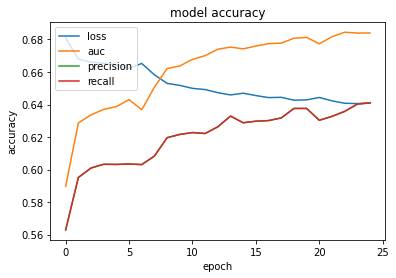

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['auc'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['recall'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss','auc','precision','recall'], loc='upper left')
plt.show()

In [ ]:
# evaluate model on train set
accuracy = model.evaluate(train_x, train_y,batch_size=batch_size, verbose=1)
print(accuracy)

164/164 [==============================] - 3s 17ms/step - loss: 0.6383 - accuracy: 0.6386 - auc: 0.6897 - recall: 0.6386 - precision: 0.6386
[0.6382895708084106, 0.6386337280273438, 0.689656138420105, 0.6386337280273438, 0.6386337280273438]


In [ ]:
# evaluate model on test set
accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
print(accuracy)

KeyboardInterrupt: ignored

In [ ]:
model.save('models/LSTM/28-09-2020')

INFO:tensorflow:Assets written to: models/LSTM/24-09-2020/assets


Bidirectional LSTM
* Epochs 30, Train- 65, Test-76
* Epochs 40, Train- 68, Test-70 
* Epochs 50, Train- 68. Test-73

Random ones find the maximum

In [ ]:
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(100),  input_shape=(n_timesteps,n_features)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(100, activation='relu'))
model_bi.add(Dense(n_outputs, activation='softmax'))
model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_bi.summary())
verbose, epochs, batch_size = 1, 25, 64
# fit network
model_bi.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 200)               81600     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 202       
Total params: 101,902
Trainable params: 101,902
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
164/164 [==============================] - 11s 66ms/step - loss: 0.6668 - accuracy: 0.5924
Epoch 2/25
164/164 [==============================] - 11s 64ms/step - loss: 0.6533 - accuracy: 0.6155
Epoch 3/25
164/164 [================

In [ ]:
# evaluate model on train set
_, accuracy = model_bi.evaluate(train_x, train_y, batch_size=batch_size, verbose=0)
print(accuracy)
# evaluate model on test set
_, t_accuracy = model_bi.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
print(t_accuracy)

0.6800612211227417
0.7028385400772095


In [ ]:
y_pred = model_bi.predict(test_x)
from sklearn.metrics import roc_auc_score
roc_auc_score(test_y, y_pred)

0.7266191829562831

In [ ]:
print('Shape of the train features tensor',train_x.shape)
print('Shape of the train labels tensor',train_y.shape)
print('Shape of the test features tensor',test_x.shape)
print('Shape of the test labels tensor',test_y.shape)

Shape of the train features tensor (10452, 41, 1)
Shape of the train labels tensor (10452, 2)
Shape of the test features tensor (258829, 41, 1)
Shape of the test labels tensor (258829, 2)


In [ ]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
verbose, epochs, batch_size = 0, 64, 64
print('Timesteps, number of features, n_outputs',n_timesteps,n_features,n_outputs)
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
_, accuracy_train = model.evaluate(train_x, train_y, batch_size=batch_size, verbose=0)
print('Accuracy on train dataset',accuracy_train)
_, accuracy_test = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
print('Accuracy on train dataset',accuracy_test)

Timesteps, number of features, n_outputs 41 1 2
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 202       
Total params: 51,102
Trainable params: 51,102
Non-trainable params: 0
_________________________________________________________________
None
Accuracy on train dataset 0.6775736808776855
Accuracy on train dataset 0.7831193804740906


*   Epochs 15, Train 62, Test 75
*   Epochs 50, Train, 67, Test 81
*   Epoch 64, Train 67, Test 78
*   Epoch 100, Train 75, Test 67

In [ ]:
def evaluate_model(train_x, train_y, test_x, test_y):
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  verbose, epochs, batch_size = 1, 50, 64
  print('Timesteps, number of features, n_outputs',n_timesteps,n_features,n_outputs)
  model = Sequential()
  model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  _, accuracy_train = model.evaluate(train_x, train_y, batch_size=batch_size, verbose=0)
  print('Accuracy on train dataset',accuracy_train)
  _, accuracy_test = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
  print('Accuracy on train dataset',accuracy_test)
  return accuracy_test,model

In [ ]:
# repeat experiment
repeats = 10
max_s = 0
for r in range(repeats):
  print('Iteration number ',r,'Fitting the model')
  acc_test,model = evaluate_model(train_x, train_y, test_x, test_y)
  if acc_test > max_s:
    max_s = acc_test
    model.save("model_best")

Iteration number  0 Fitting the model
Timesteps, number of features, n_outputs 41 1 2
Epoch 1/50
164/164 [==============================] - 6s 38ms/step - loss: 0.6795 - accuracy: 0.5705
Epoch 2/50
164/164 [==============================] - 6s 39ms/step - loss: 0.6712 - accuracy: 0.5910
Epoch 3/50
164/164 [==============================] - 6s 38ms/step - loss: 0.6659 - accuracy: 0.6007
Epoch 4/50
164/164 [==============================] - 6s 39ms/step - loss: 0.6683 - accuracy: 0.5984
Epoch 5/50
164/164 [==============================] - 6s 38ms/step - loss: 0.6662 - accuracy: 0.5983
Epoch 6/50
164/164 [==============================] - 6s 38ms/step - loss: 0.6607 - accuracy: 0.6104
Epoch 7/50
164/164 [==============================] - 6s 39ms/step - loss: 0.6560 - accuracy: 0.6156
Epoch 8/50
164/164 [==============================] - 6s 38ms/step - loss: 0.6517 - accuracy: 0.6202
Epoch 9/50
164/164 [==============================] - 6s 39ms/step - loss: 0.6513 - accuracy: 0.6214
Epoch

In [ ]:
reconstructed_model = keras.models.load_model("model_best")
y_pred = reconstructed_model.predict(test_x)
from sklearn.metrics import roc_auc_score
roc_auc_score(test_y, y_pred)

0.6822151925745396

In [ ]:
import os
print( os.getcwd() )
print( os.listdir('/content') )
!zip -r /content/model_best.zip /content/model_best
from google.colab import files
files.download( "/content/model_best.zip" ) 

/content
['.config', 'train_features.csv', 'train_labels.csv', 'gdrive', 'test_labels.csv', 'model_best', 'adc.json', 'test_features.csv', 'sample_data']
  adding: content/model_best/ (stored 0%)
  adding: content/model_best/variables/ (stored 0%)
  adding: content/model_best/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model_best/variables/variables.index (deflated 62%)
  adding: content/model_best/saved_model.pb (deflated 89%)
  adding: content/model_best/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>